<a href="https://colab.research.google.com/github/souravs17031999/kaggle-problems-60daysofudacity/blob/master/hot_dog_not_hotdog_inceptionv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')
model_save_name = 'hot_dog_inception.pt'
path = F"/content/drive/My Drive/{model_save_name}"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"souravs17031999","key":"c0dfc674730fdb391ccd28e80943c438"} # copy the API from kaggle.json downloaded from kaggle account
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d dansbecker/hot-dog-not-hot-dog   # sample for downloading the dataset directly from kaggle API (can be copied from dataset kaggle page)
!unzip ./{/content}/datasets/dansbecker/hot-dog-not-hot-dog/hot-dog-not-hot-dog.zip

In [3]:
import torch
from torch import optim, nn
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import PIL
print(PIL.PILLOW_VERSION)
!wget -c https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py # importing udacity helper module to visualize images directly

4.3.0
--2019-07-26 05:47:40--  https://raw.githubusercontent.com/udacity/deep-learning-v2-pytorch/master/intro-to-pytorch/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2813 (2.7K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   2.75K  --.-KB/s    in 0s      

2019-07-26 05:47:40 (65.9 MB/s) - ‘helper.py’ saved [2813/2813]



In [11]:
# SETTING THE DIRECTORIES
train_dir = 'train'
test_dir = 'test'

# APPLYING THE APPROPRIATE TRANSFORMS
train_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomResizedCrop(299),transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(301),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# IMPORTING / DOWNLOADING THE DATASET
train_data = datasets.ImageFolder(train_dir , transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

# DIVIDING TRAINING SET INTO TRAIN SET AND VALIDATION SET
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# SAMPLING 
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# LOADING WITH DATA AUGMENTED
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 498
testing examples contain : 500
7
2
8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape : torch.Size([64, 3, 299, 299])
Label shape : torch.Size([64])
labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


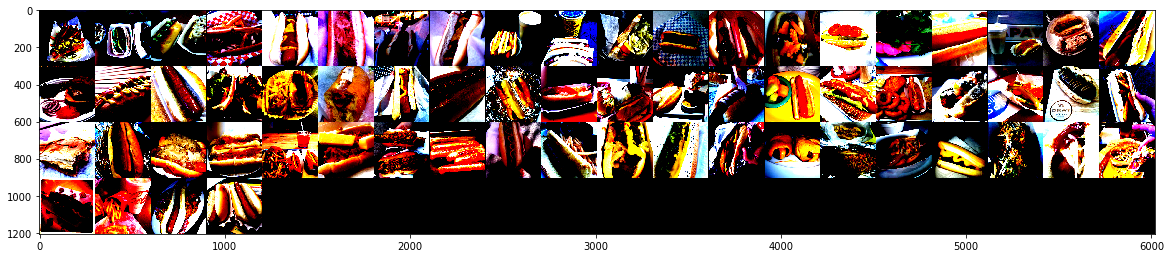

In [12]:
# LOAD ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(testloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

class_names = train_data.classes

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# plotting the images of loaded batch with given fig size and frame data    
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)    



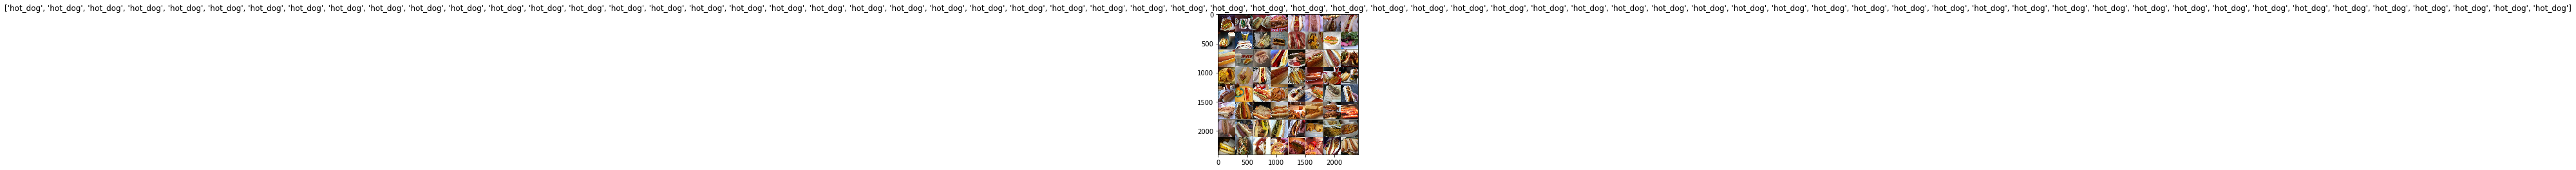

In [13]:
# Printing normalized images
images, labels = next(iter(testloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

In [8]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [0]:
# defining device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# downloading model
model = models.inception_v3(pretrained=True)
# only for inception
model.aux_logits=False
  
# setting firstly classifier only for training 
for param in model.parameters():
  param.requires_grad = False
num_ftrs = model.fc.in_features
# output classes
out_ftrs = 2
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))
# defining the loss function 
criterion = nn.NLLLoss()
  
# defining the optimizer and scheduler
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.fc.parameters()) , lr = 0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

# sending the model to device - GPU OR CPU
model.to(device);
 


In [0]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses = [] , []
    valid_loss_min = np.Inf 
    model.train()
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      scheduler.step()
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        print(f" epoch {epoch + 1} batch {batch} completed")
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': valid_loss_min
            }, path)
        valid_loss_min = test_loss/len(validloader)    
    print(f"Best validation accuracy : {accuracy/len(validloader)}")
    print(f"Best loss obtained : {valid_loss_min}")

In [34]:
train_and_test(50)

 epoch 1 batch 1 completed
 epoch 1 batch 2 completed
 epoch 1 batch 3 completed
 epoch 1 batch 4 completed
 epoch 1 batch 5 completed
 epoch 1 batch 6 completed
 epoch 1 batch 7 completed
Epoch: 1/50..  Training Loss: 0.533..  Valid Loss: 0.482..  Valid Accuracy: 0.817
Validation loss decreased (inf --> 0.481744).  Saving model ...
 epoch 2 batch 1 completed
 epoch 2 batch 2 completed
 epoch 2 batch 3 completed
 epoch 2 batch 4 completed
 epoch 2 batch 5 completed
 epoch 2 batch 6 completed
 epoch 2 batch 7 completed
Epoch: 2/50..  Training Loss: 0.449..  Valid Loss: 0.451..  Valid Accuracy: 0.819
Validation loss decreased (0.481744 --> 0.451154).  Saving model ...
 epoch 3 batch 1 completed
 epoch 3 batch 2 completed
 epoch 3 batch 3 completed
 epoch 3 batch 4 completed
 epoch 3 batch 5 completed
 epoch 3 batch 6 completed
 epoch 3 batch 7 completed
Epoch: 3/50..  Training Loss: 0.424..  Valid Loss: 0.387..  Valid Accuracy: 0.823
Validation loss decreased (0.451154 --> 0.386771).  Sa

In [0]:
def load_model(path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  return model

In [0]:
model = load_model(path)

In [45]:
# to unfreeze more layers 
for name,child in model.named_children():
  if name in ['Mixed_6e','Mixed_6d','Mixed_6c','Mixed_6b','Mixed_6a','Mixed_7c','Mixed_7b','Mixed_7a','fc']:
    print(name + 'is unfrozen')
    for param in child.parameters():
      param.requires_grad = True
  else:
    print(name + 'is frozen')
    for param in child.parameters():
      param.requires_grad = False

Conv2d_1a_3x3is frozen
Conv2d_2a_3x3is frozen
Conv2d_2b_3x3is frozen
Conv2d_3b_1x1is frozen
Conv2d_4a_3x3is frozen
Mixed_5bis frozen
Mixed_5cis frozen
Mixed_5dis frozen
Mixed_6ais unfrozen
Mixed_6bis unfrozen
Mixed_6cis unfrozen
Mixed_6dis unfrozen
Mixed_6eis unfrozen
AuxLogitsis frozen
Mixed_7ais unfrozen
Mixed_7bis unfrozen
Mixed_7cis unfrozen
fcis unfrozen


In [0]:
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.parameters()) , lr = 0.00001)

In [47]:
train_and_test(30)

 epoch 1 batch 1 completed
 epoch 1 batch 2 completed
 epoch 1 batch 3 completed
 epoch 1 batch 4 completed
 epoch 1 batch 5 completed
 epoch 1 batch 6 completed
 epoch 1 batch 7 completed
Epoch: 1/30..  Training Loss: 0.069..  Valid Loss: 0.325..  Valid Accuracy: 0.844
Validation loss decreased (inf --> 0.325340).  Saving model ...
 epoch 2 batch 1 completed
 epoch 2 batch 2 completed
 epoch 2 batch 3 completed
 epoch 2 batch 4 completed
 epoch 2 batch 5 completed
 epoch 2 batch 6 completed
 epoch 2 batch 7 completed
Epoch: 2/30..  Training Loss: 0.103..  Valid Loss: 0.320..  Valid Accuracy: 0.871
Validation loss decreased (0.325340 --> 0.320218).  Saving model ...
 epoch 3 batch 1 completed
 epoch 3 batch 2 completed
 epoch 3 batch 3 completed
 epoch 3 batch 4 completed
 epoch 3 batch 5 completed
 epoch 3 batch 6 completed
 epoch 3 batch 7 completed
Epoch: 3/30..  Training Loss: 0.056..  Valid Loss: 0.265..  Valid Accuracy: 0.880
Validation loss decreased (0.320218 --> 0.265053).  Sa

In [48]:
accuracy = 0
with torch.no_grad():
    model.eval()
    p_labels = []
    img_ids = []
    i = 0
    for inputs, labels in testloader:
        i += 1
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        temp_acc = torch.sum(preds == labels.data)
        accuracy += temp_acc
        p_labels.append(preds)
    # getting ids of file images    
    for dir in os.listdir(test_dir):
        for file in os.listdir(os.path.join(test_dir, dir)):
            img_id = os.path.splitext(file)[0]
            img_ids.append(img_id)
    print('Accuracy =====>>', accuracy.item()/len(test_data))

Accuracy =====>> 0.906


In [0]:
# getting our predictions as py list 
pred = []
for i in p_labels:
  for j in i:
    pred.append(j.item())

submission = pd.DataFrame({'Id': img_ids,'Predicted': pred})
submission.to_csv('submission.csv', index=False)